# Data Explorer

This notebook provides tools and visualizations to explore and analyze datasets in the project.

**Project:** CondGeoLDM  
**Author:** Pierre  
**Date:** 2024-06


## Basic file loading


In [1]:
import numpy as np
from rdkit import Chem
import numpy as np
from os.path import join
import pandas as pd
import tqdm 
import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

from pathlib import Path
import torch.multiprocessing as mp

from equivariant_diffusion.utils import assert_correctly_masked
import qm9.visualizer as vis
from qm9.models import get_latent_diffusion
from configs.datasets_config import get_dataset_info
from qm9 import dataset, losses

io_path = Path("/import/pr_iktos/pierre/CondGeoLDM")
model_path = "outputs/jump_xatt_h_3000%_25e_resume_resume_resume"
with open(io_path / model_path /  "args.pickle", "rb") as f:
    args = pickle.load(f)
args.model_path = model_path
args.datadir = str(io_path)
args.data_file = io_path / "data" / "jump" / "charac_30_h.npy"
dataloaders, charge_scale = dataset.retrieve_dataloaders(args)
train_loaders = dataloaders["train"]
train_phenotypes = []
for i, batch in tqdm.tqdm(enumerate(train_loaders)):
    emb = batch['embeddings'].clone()
    train_phenotypes.append(emb)

Loading JUMP dataset from /import/pr_iktos/pierre/CondGeoLDM/data/jump/charac_30_h.npy


42106it [58:21, 12.03it/s]


In [2]:

# Save to .npy
np.save('/projects/iktos/pierre/CondGeoLDM/data/jump/train_embeddings.npy', train_phenotypes, allow_pickle=True)

/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/numpy/lib/npyio.py:521: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (42106,) + inhomogeneous part.

In [206]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rdkit.Chem import rdDetermineBonds
import pandas as pd 

raw_data_path = pd.read_parquet( "/projects/iktos/pierre/CondGeoLDM/data/jump/raw_data/metadata.parquet")

def mol_from_inchi(inchi):
    """Convert InChI string to RDKit molecule."""
    mol = Chem.MolFromInchi(inchi, sanitize=False, removeHs=False)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    
    if mol is None:
        raise ValueError("Failed to convert InChI to molecule")
    return mol

def mol_from_xyz_file(xyz_path):
    """Read XYZ file and create RDKit molecule with inferred bonds."""
    with open(xyz_path, 'r') as f:
        lines = f.readlines()
    
    # Parse XYZ format
    n_atoms = int(lines[0].strip())
    # Skip comment line
    atoms_data = lines[2:2+n_atoms]
    
    # Create editable molecule
    mol = Chem.RWMol()
    conf = Chem.Conformer(n_atoms)
    
    for i, line in enumerate(atoms_data):
        parts = line.strip().split()
        symbol = parts[0]
        x, y, z = map(float, parts[1:4])
        
        # Add atom
        atom = Chem.Atom(symbol)
        mol.AddAtom(atom)
        
        # Add coordinates
        conf.SetAtomPosition(i, (x, y, z))
    
    mol.AddConformer(conf)
    
    # Infer bonds based on distances
    mol = mol.GetMol()
    mol = Chem.Mol(mol)
    # AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    # mol = Chem.AddHs(mol)

    Chem.SanitizeMol(mol)
    
    return mol

def get_coords(mol):
    conf = mol.GetConformer()
    return [conf.GetAtomPosition(i) for i in range(mol.GetNumAtoms())]

def plot_bonds_3d(ax, mol, coords, atom_color="blue"):
    """Plot bonds as lines between connected atoms."""
    xs, ys, zs = zip(*[(p.x, p.y, p.z) for p in coords])
    
    # Plot atoms
    ax.scatter(xs, ys, zs, c=atom_color, s=60)
    
    # Plot bonds
    for bond in mol.GetBonds():
        atom1_idx = bond.GetBeginAtomIdx()
        atom2_idx = bond.GetEndAtomIdx()
        
        # Get coordinates of the two atoms
        x1, y1, z1 = xs[atom1_idx], ys[atom1_idx], zs[atom1_idx]
        x2, y2, z2 = xs[atom2_idx], ys[atom2_idx], zs[atom2_idx]
        
        # Draw line between atoms
        ax.plot([x1, x2], [y1, y2], [z1, z2], 'k-', linewidth=1, alpha=0.8)
    
    # Add atom labels
    for i, atom in enumerate(mol.GetAtoms()):
        ax.text(xs[i], ys[i], zs[i], atom.GetSymbol(), fontsize=10)




    
def align_and_rmsd(mol_ref, mol_fit):
    """
    Align mol_fit onto mol_ref, return (rmsd, aligned_mol).
    Both molecules are copied, so originals stay untouched.
    If a molecule has no conformer, a 3D conformer is generated.
    """
    mol1 = Chem.Mol(mol_ref)
    mol2 = Chem.Mol(mol_fit)
    
    # Ensure both molecules have conformers
    if mol1.GetNumConformers() == 0:
        mol1 = Chem.AddHs(mol1)
        AllChem.EmbedMolecule(mol1, AllChem.ETKDG())
    
    if mol2.GetNumConformers() == 0:
        mol2 = Chem.AddHs(mol2)
        AllChem.EmbedMolecule(mol2, AllChem.ETKDG())
    
    # Copy mol2 so original is unchanged
    mol2_aligned = Chem.Mol(mol2)
    
    # Compute alignment
    rmsd = rdMolAlign.AlignMol(mol2_aligned, mol1)
    print(f"RMSD = {rmsd:.3f} Å")
    return rmsd, mol2_aligned
# Read XYZ file


0


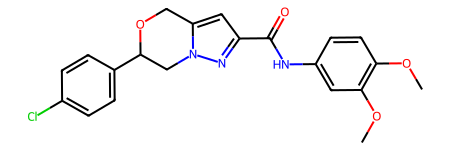

In [312]:
# Load INCHIS FROM GT METADATA 
a = Chem.MolFromInchi(inchis_raw[2], sanitize=False, removeHs=False)
print(a.GetNumConformers())
a

0


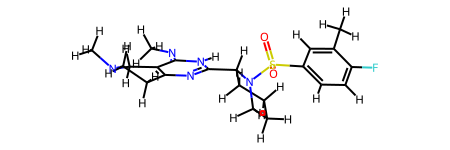

In [353]:
# GENERATE 3D CONFORMER
a =Chem.AddHs(Chem.MolFromInchi(inchis_raw[5], sanitize=False, removeHs=False))
print(a.GetNumConformers())
AllChem.EmbedMolecule(a , AllChem.ETKDG())
a


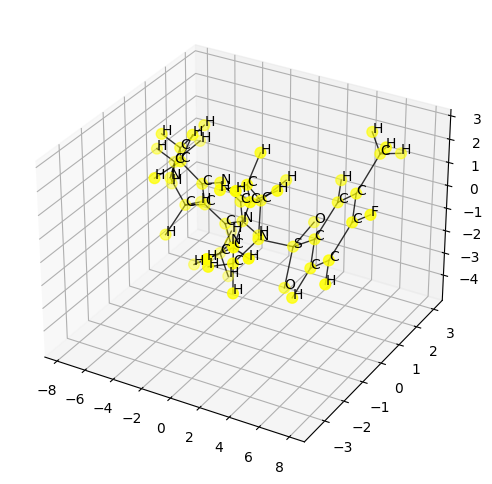

In [354]:
# GENERATE XYZ FILE
conf = a.GetConformer(0)
n_atoms = a.GetNumAtoms()

lines = [str(n_atoms), "Generated by RDKit"]
for atom in a.GetAtoms():
    pos = conf.GetAtomPosition(atom.GetIdx())
    symbol = atom.GetSymbol()
    lines.append(f"{symbol} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}")
# print("\n".join(lines))

ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
plot_bonds_3d(ax, a, get_coords(a), atom_color="yellow")

RAW XYZ FILE:


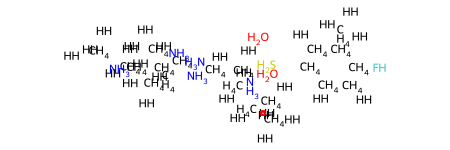

In [355]:
# SAVE AND RELOAD XYZ FILE
xyz_file = "\n".join(lines)
with open(f"/projects/iktos/pierre/CondGeoLDM/temp/molecule2.xyz", 'w') as f:
    f.write(xyz_file)
with open(f"/projects/iktos/pierre/CondGeoLDM/temp/molecule2.xyz", 'r') as f:
    lines = f.readlines()
print("RAW XYZ FILE:")
mol_from_xyz_file(f"/projects/iktos/pierre/CondGeoLDM/temp/molecule2.xyz")

1
RAW SDF FILE, NO SANITIZE:


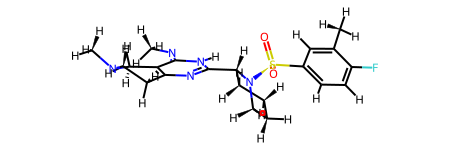

In [360]:
# LOAD SDF FILE
a_sdf = Chem.SDMolSupplier('/projects/iktos/pierre/CondGeoLDM/temp/molecule2.sdf', sanitize=False, removeHs=False)[0]
print(a.GetNumConformers())
print("RAW SDF FILE, NO SANITIZE:")
a_sdf

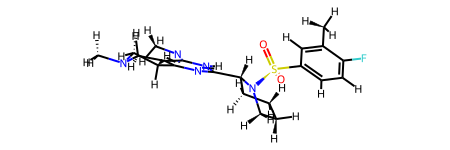

In [361]:
a_sdf_clean = Chem.Mol(a_sdf)
Chem.SanitizeMol(a_sdf_clean) #operates in place
# a_sdf_clean= Chem.AddHs(a_sdf_clean, addCoords=True)
Chem.GetMolFrags(a_sdf_clean)
AllChem.UFFOptimizeMolecule(a_sdf_clean, maxIters=200)

largest_frag = max(Chem.GetMolFrags(a_sdf_clean, asMols=True), key=lambda m: m.GetNumAtoms()    )
largest_frag

In [362]:
# COMPARE FP
from metrics import fidelity
import numpy as np
from skfp.distances.tanimoto import tanimoto_binary_similarity
fp_sdf = fidelity.rdkit_mols_to_fingerprints([largest_frag])
fp_sdf_1 = fidelity.rdkit_mols_to_fingerprints([a_sdf])
fp_inchi = fidelity.rdkit_mols_to_fingerprints([a])
tanimoto_binary_similarity(fp_sdf, fp_inchi), tanimoto_binary_similarity(fp_sdf_1, fp_inchi), tanimoto_binary_similarity(fp_sdf, fp_sdf_1)

(0.4421052631578947, 1.0, 0.4421052631578947)

Inchis from SDF = Inchi from file ? : False
RMSD = 2.363 Å


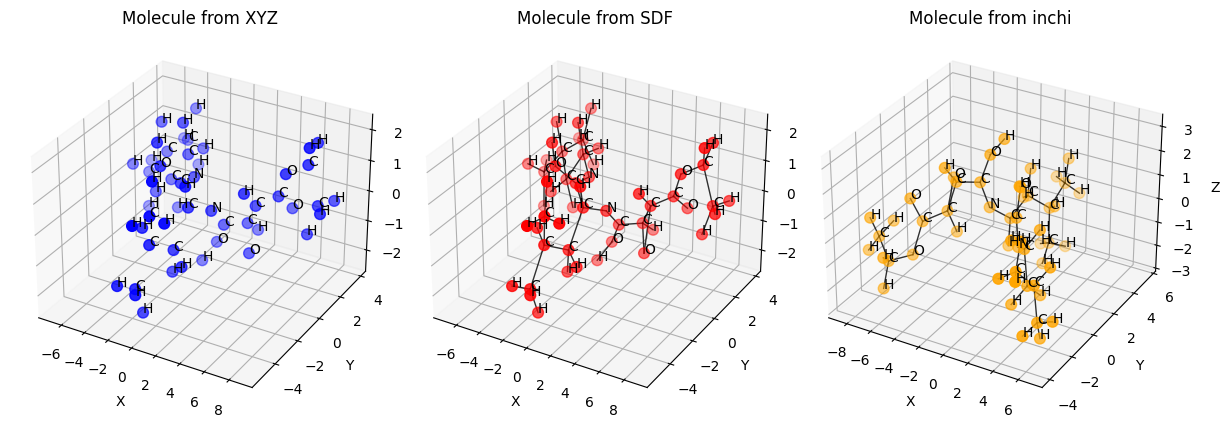

Inchis from SDF = Inchi from file ? : True
RMSD = 1.348 Å


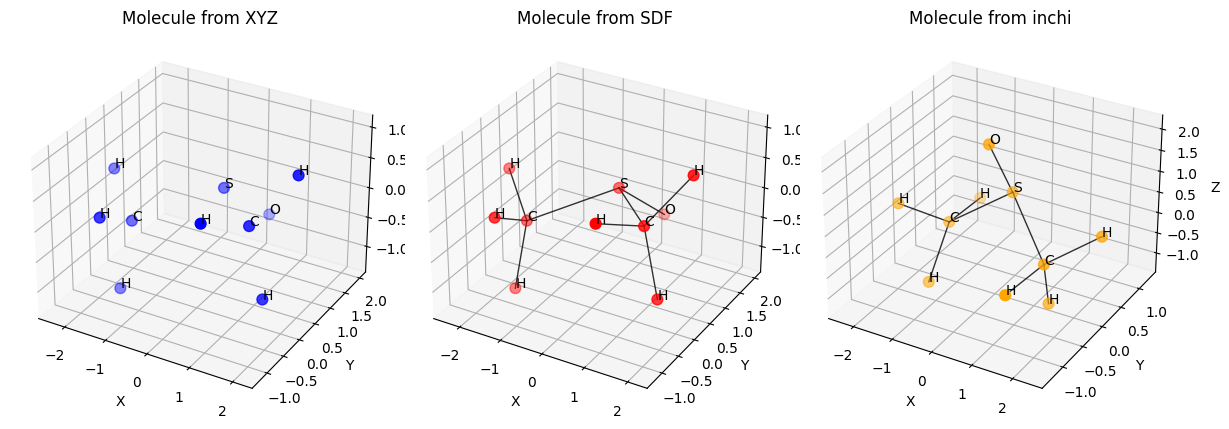

Inchis from SDF = Inchi from file ? : False
RMSD = 1.599 Å


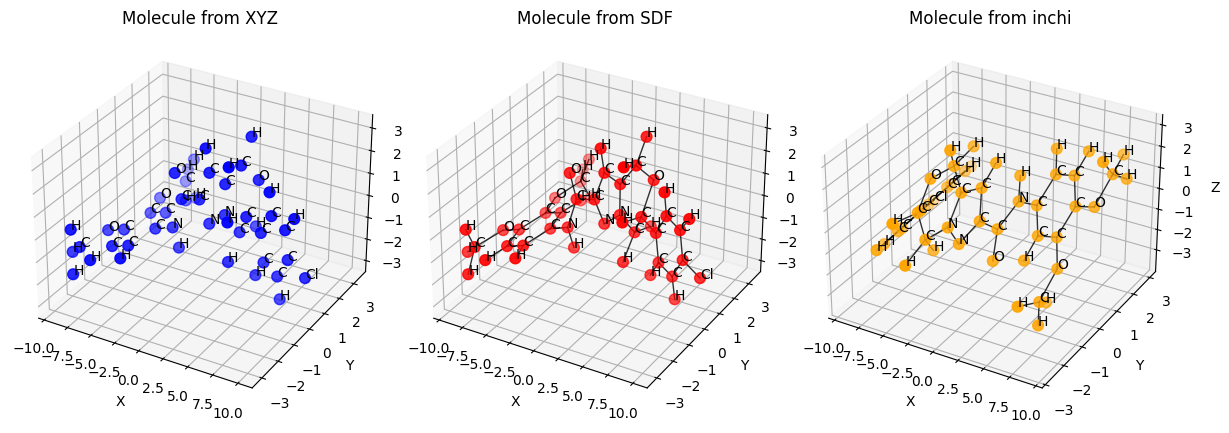

Inchis from SDF = Inchi from file ? : False
RMSD = 2.099 Å


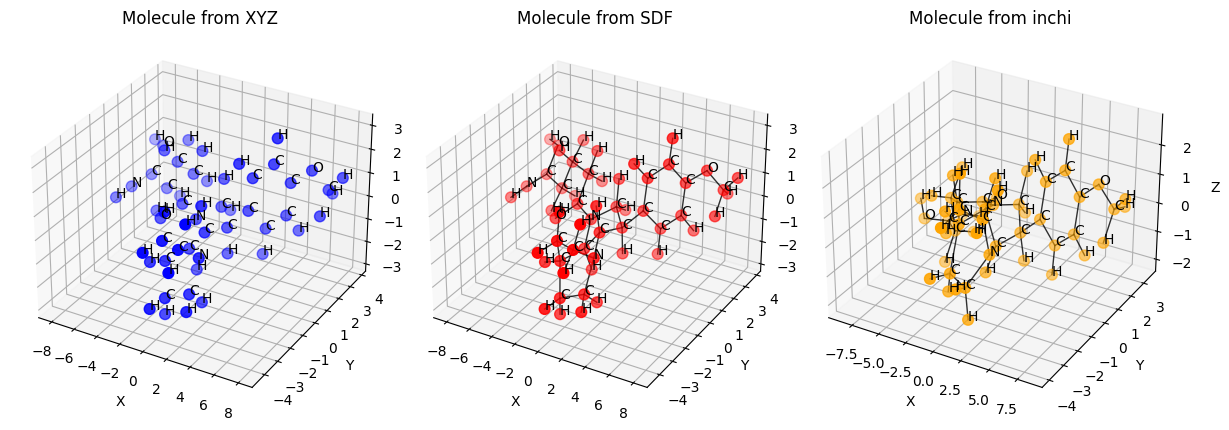

In [ ]:
from rdkit.Chem import rdMolAlign

inchis_raw = raw_data_path['Metadata_InChI'].tolist()

for i in range(4):
     # --- Load molecules---
    xyz_path = f"/projects/iktos/pierre/CondGeoLDM/data/jump/raw_data/xyz_files/molecule{i}.xyz"
    mol_xyz = mol_from_xyz_file(xyz_path)

    sdf_path = "/projects/iktos/pierre/CondGeoLDM/data/jump/raw_data/jump_molecules_ordered.sdf"
    suppl = Chem.SDMolSupplier(sdf_path, sanitize=False, removeHs=False)
    mol_sdf = suppl[i]  # Get the i-th molecule
    mol_sdf_clean = Chem.Mol(mol_sdf)
    Chem.SanitizeMol(mol_sdf_clean)
    if mol_sdf is None:
        raise ValueError("Failed to read SDF file")
    temp = Chem.MolToInchi(mol_sdf)

    mol_inchi = mol_from_inchi(inchis_raw[i])
    print("Inchis from SDF = Inchi from file ? :", temp ==inchis_raw[i])
    coords_xyz = get_coords(mol_xyz)
    coords_sdf = get_coords(mol_sdf)
    coords_inchi = get_coords(mol_inchi)
        
    try :
        align_and_rmsd(mol_inchi, mol_sdf)
    except :
        print("Alignment failed")
    # --- Plot in 3D with bonds ---
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(131, projection="3d")
    ax1.set_title("Molecule from XYZ")
    plot_bonds_3d(ax1, mol_xyz, coords_xyz, atom_color="blue")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    ax2 = fig.add_subplot(132, projection="3d")
    ax2.set_title("Molecule from SDF")
    plot_bonds_3d(ax2, mol_sdf, coords_sdf, atom_color="red")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    ax3 = fig.add_subplot(133, projection="3d")
    ax3.set_title("Molecule from inchi")
    plot_bonds_3d(ax3, mol_inchi, coords_inchi, atom_color="orange")
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

    
    


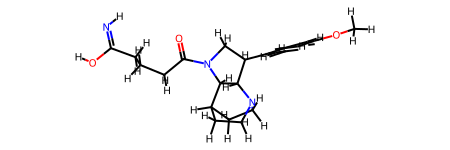

In [200]:
mol_inchi

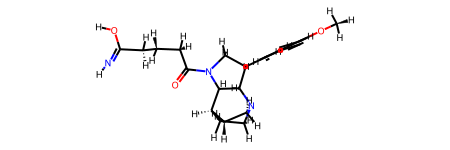

In [201]:
mol_sdf

In [1]:
from metrics import fidelity
fp = fidelity.read_fingerprints_file('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/jump_fingerprints.npy')
fp_temp = fidelity.read_fingerprints_file('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/jump_fingerprints_temp.npy')
fp_unsanitized = fidelity.read_fingerprints_file('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/jump_fingerprints_unsanitized.npy')
print("original,", fp.shape, "from sdf,", fp_temp.shape, 'dirty,',fp_unsanitized.shape)

original, (112288, 1024) from sdf, (105976, 1024) dirty, (112295, 1024)


## Modify args.pickle in checkpoints

In [1]:
import pickle
print(os.getcwd())
args_path = '/projects/iktos/pierre/CondGeoLDM/outputs/geom_pretrained/args.pickle'
with open(args_path, 'rb') as f:
    args_j = pickle.load(f)
args_j

#MODIFY YOUR ARGS HERE 
args_j.datadir = "/import/pr_iktos/pierre/CondGeoLDM"
# # # Uncomment to save args_j
with open(args_path, 'wb') as f:
    pickle.dump(args_j, f)

NameError: name 'os' is not defined

# Tanimoto Similarities


In [1]:
import numpy as np
import pandas as pd
import metrics.fidelity as fidelity
from metrics.fidelity import compute_stacked_histogram, read_fingerprints_file
from importlib import reload
reload(fidelity)
# rax fp
geom_fp = read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/geom_fingerprints.npy")
jump_fp = read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/jump_fingerprints.npy")
jump_fp_unsanitized = read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/jump_fingerprints_unsanitized.npy")
jump_fp_temp = read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/jump_fingerprints_temp.npy")
self_sim_geom = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/self_sim_geom.npy', allow_pickle=True)
self_sim_qm9 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/self_sim_qm9.npy', allow_pickle=True)

#refs
mal_jump_50k = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jump_50k.npy', allow_pickle=True)
mal_qm9_20k= np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_qm9_20k.npy', allow_pickle=True)
mal_geom_50k = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_geom_50k.npy', allow_pickle=True)

#mallat geom
mal_geoLDM = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_geoldm.npy', allow_pickle=True)
mal_semla = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_semla.npy', allow_pickle=True)
mal_flowmol = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_flowmol.npy', allow_pickle=True)
mal_gcdm= np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_gcdm.npy', allow_pickle=True)

# mallat qm9
mal_semla_qm9 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_semla_qm9.npy', allow_pickle=True)
mal_gcdm_qm9 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_gcdm_qm9.npy', allow_pickle=True)
mal_semla_nopp = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_semla_nopp.npy', allow_pickle=True)

#mallat jump
mal_jumpxatt = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpxatt.npy', allow_pickle=True)
mal_jumpxattresume3 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpxattresume3.npy', allow_pickle=True)
mal_jumpvanilla = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpvanilla.npy', allow_pickle=True)
mal_jump0 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpphen0.npy', allow_pickle=True)
mal_jump1 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpphen1.npy', allow_pickle=True)
mal_jump2 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpphen2.npy', allow_pickle=True)
print(len(geom_fp))

268658


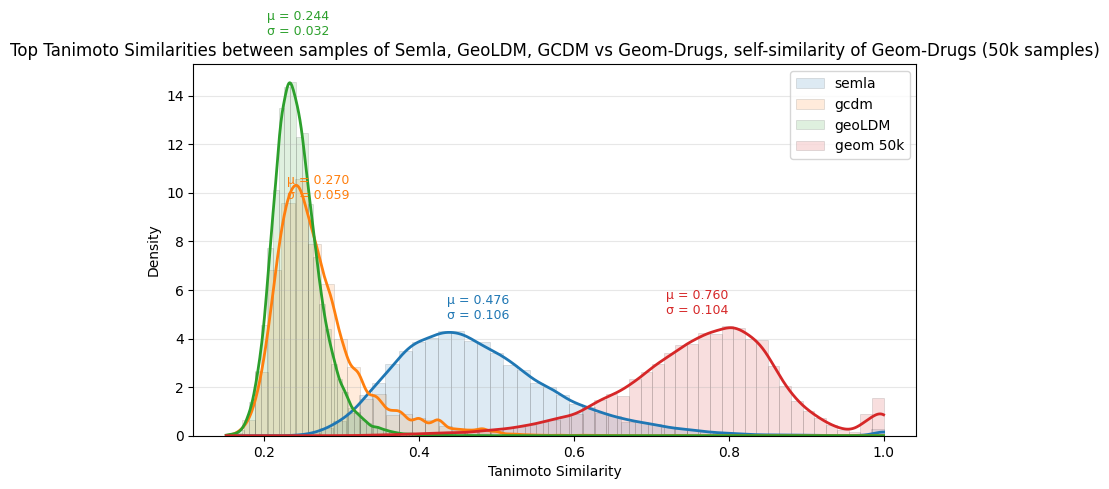

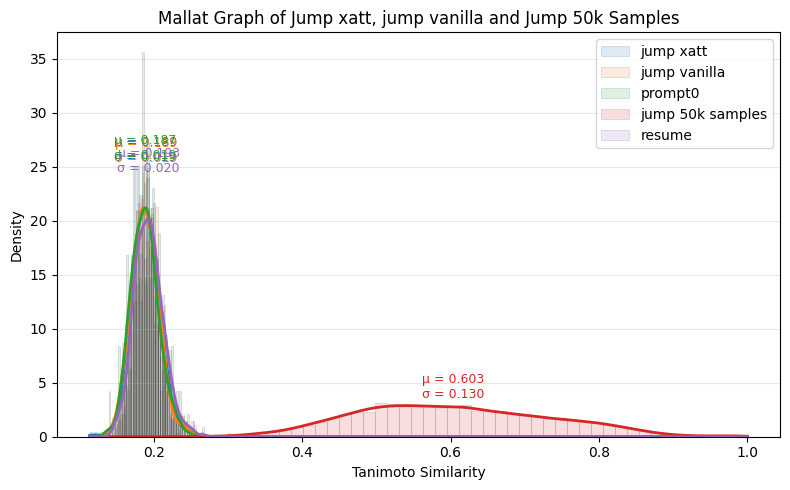

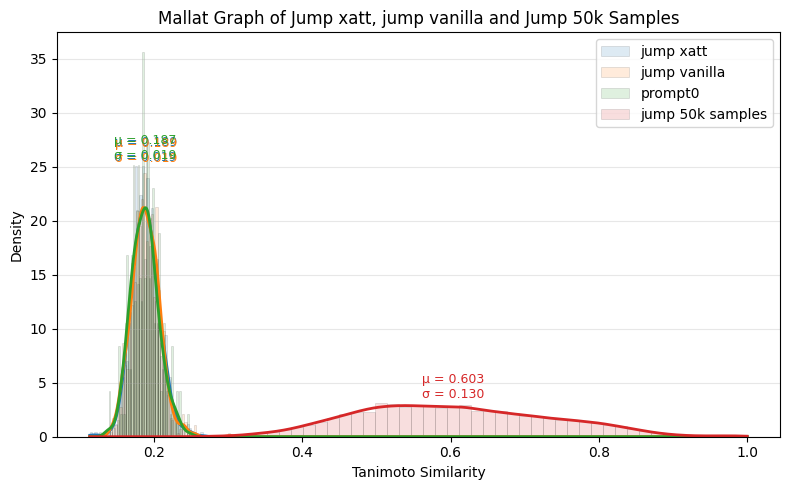

In [7]:

compute_stacked_histogram([mal_semla[:,0], mal_gcdm[:,0], mal_geoLDM[:,0], mal_geom_50k[:,0],  ],
                          labels=["semla","gcdm","geoLDM", "geom 50k"  ],
                          save_path="metrics/figures/mallat_test_global.png", 
                          bins=50,
                          title="Top Tanimoto Similarities between samples of Semla, GeoLDM, GCDM vs Geom-Drugs, self-similarity of Geom-Drugs (50k samples)")
                          
                        #   labels= ["Similarities of Flowmol generations", "Similarities of Semla generations", "Similarities of GCDM generations", "Similarities of GEOM_50k"],
                        #   save_path="metrics/figures/mallat_global_50k.png", 
                        #   title="Mallat Graph of Flowmol, Semla and GCDM Samples trained on GEOM (50k samples)")

compute_stacked_histogram([mal_jumpxatt[:,0], mal_jumpvanilla[:,0], mal_jump0[:,0],mal_jump_50k[:,0],mal_jumpxattresume3[:,0]],
                          labels=["jump xatt", "jump vanilla" , "prompt0", "jump 50k samples", "resume"],
                          save_path="metrics/figures/mallat_jump_global.png", 
                          bins=50,
                          title="Mallat Graph of Jump xatt, jump vanilla and Jump 50k Samples")

compute_stacked_histogram([mal_jumpxatt[:,0], mal_jumpvanilla[:,0], mal_jump0[:,0],mal_jump_50k[:,0]],
                          labels=["jump xatt", "jump vanilla" , "prompt0", "jump 50k samples"],
                          save_path="metrics/figures/mallat_jump_global.png", 
                          bins=50,
                          title="Mallat Graph of Jump xatt, jump vanilla and Jump 50k Samples")

## Test of fidelity metrics


In [2]:
import os
from metrics import fidelity
import numpy as np

import eval_script
import pickle
import torch
import argparse
from equivariant_diffusion.utils import assert_correctly_masked
from qm9.sampling import sample_chain, sample
import qm9.visualizer as vis
from qm9.models import get_latent_diffusion
from configs.datasets_config import get_dataset_info
from qm9 import dataset, losses
from metrics.viability import analyze_stability_for_molecules, check_stability
from importlib import reload
parser = argparse.ArgumentParser(
    description="Sample mol with conditioning drawn from clusters")

# parser.add_argument(
#     "--n_samples", type=int, default=10, help="Number of samples to generate")
# parser.add_argument(
#     "--n_tries",type=int, default=50,help="Number of tries to find stable molecules",)
# parser.add_argument(
#     "--data_file",type=str, default="/projects/iktos/pierre/CondGeoLDM/data/jump/charac_30_h.npy",
#     help="Conditioning type: geom, jump, or both")

# parser.add_argument("--model_path", type=str, default="/projects/iktos/pierre/CondGeoLDM/outputs/only_ae")
# parser.add_argument("--stable_only", type=bool, default="False")
# parser.add_argument("--visualise_chain", type=bool, default="False")
# parser.add_argument("--save_samples", type=bool, default = "False")
# parser.add_argument(
#     "--n_nodes",type=int, default=44 ,help="Size of fixed-sized generation")
# # Parse the arguments
# eval_args, _ = parser.parse_known_args()
# print(eval_args)
# assert eval_args.model_path is not None

# with open(os.path.join(eval_args.model_path, "args.pickle"), "rb") as f:
#     args = pickle.load(f)

# args.cuda = not args.no_cuda and torch.cuda.is_available()
# device = torch.device("cuda" if args.cuda else "cpu")
# args.device = device
# dtype = torch.float32

# # Retrieve dataset info and dataloaders
# dataset_info = get_dataset_info(args.dataset, args.remove_h)

# dataloaders, charge_scale = dataset.retrieve_dataloaders(args)

# flow, nodes_dist, prop_dist = get_latent_diffusion(
#     args, device, dataset_info, dataloaders["train"]
# )
# # if prop_dist is not None:
# #     property_norms = compute_mean_mad(dataloaders, args.conditioning, args.dataset)
# #     prop_dist.set_normalizer(property_norms)
# flow.to(device)

# fn = "generative_model_ema.npy" if args.ema_decay > 0 else "generative_model.npy"
# flow_state_dict = torch.load(os.path.join(eval_args.model_path, fn), map_location=device)
# flow.load_state_dict(flow_state_dict)

In [ ]:
sum(p.numel() for p in flow.parameters())
sum(p.numel() for p in flow.parameters() if p.requires_grad)

5482021

: 

In [12]:
vae_state_dict = flow.vae.state_dict()
vae_np_dict = {k: v.cpu().numpy() for k, v in vae_state_dict.items()}
torch.save(flow.vae.state_dict(), "/projects/iktos/pierre/CondGeoLDM/outputs/jump_xatt_h_3000%_25e_resume/vae/generative_model_ema.npy")

with open('outputs/jump_xatt_h_3000%_25e_resume/vae/args.pickle', 'wb') as f:
    pickle.dump(args, f)

In [ ]:
sum(p.numel() for p in flow.vae.parameters() if p.requires_grad)
sum(p.numel() for p in flow.vae.parameters() if p.requires_grad)

# flow

2373383


3108638

In [68]:
reload(eval_script)
one_hot, charges, x, node_mask = eval_script.sample_only_stable_different_sizes(
    args,
    eval_args,
    device,
    flow,
    nodes_dist,
    dataset_info,
    n_samples=50,
    n_tries=51,
    save=eval_args.save_samples,
)

0it [00:00, ?it/s]

1000it [06:12,  2.68it/s]


In [ ]:

reload(eval_script)
molecules_list = eval_script.graph_to_mol_list(one_hot=one_hot, charges=charges, x=x, node_mask=node_mask)
stability_dict, rdkit_metrics, mols = analyze_stability_for_molecules(
    molecules_list, 
    dataset_info,
    parallel=False
)
# TODO : GetLargestFragment(mol) change til les distances tanimoto ? 
print(stability_dict, rdkit_metrics)

Computing stability: 100%|██████████| 50/50 [00:03<00:00, 15.90it/s]
[15:43:36] Explicit valence for atom # 19 N, 4, is greater than permitted


Validity over 50 molecules: 98.00%

              Connectivity over 50 molecules: 40.00%
Uniqueness over 49 valid molecules: 100.00%
{'mol_stable': 0.0, 'atm_stable': 0.7734194739270881} [0.98, 1.0, 0.0, 0.4]


In [70]:
mols

In [ ]:
for i in range(mols.size()[0]):
    save_xyz_file(
        f"./temp/nul/{i}",
        one_hot[i].unsqueeze(0),
        charges[i].unsqueeze(0),
        x[i].unsqueeze(0),
        dataset_info,
        0,
        "",
        node_mask[i].unsqueeze(0))

In [18]:
# reload(fidelity)
from metrics import fidelity 

fp = fidelity.rdkit_mols_to_fingerprints(mols, fp_size=1024)
print(len(fp))
fidelity.save_fingerprints_file(fp, '/projects/iktos/pierre/CondGeoLDM/TEMPFP_jump')

39


In [21]:
# - visualiser les générations 
# Parameters
import matplotlib.pyplot as plt
from PIL import Image
n_images = 10
gen_folder = "temp/samples"
gt_folder = "temp/gt"

# Prepare image grid
fig, axes = plt.subplots(n_images, 2, figsize=(6, n_images * 2.5))

for i in range(n_images):
    # File names
    gen_path = os.path.join(gen_folder, f"{i}_01_000.png")
    gt_path = os.path.join(gt_folder, f"gt{i}_01_000.png")

    # Load images
    gen_img = Image.open(gen_path)
    gt_img = Image.open(gt_path)

    # Plot
    axes[i, 0].imshow(gt_img)
    axes[i, 0].set_title(f"GT {i}, similarity {ret3[i]:4f}")
    axes[i, 1].imshow(gen_img)
    axes[i, 1].set_title(f"Generated {i}")

    for j in range(2):
        axes[i, j].axis("off")

plt.tight_layout()
plt.savefig("temp/grid.png")
plt.show()


/tmp/ipykernel_2261705/2814354691.py:32: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Umap on both DS

umap for jump distribs


Explained variance ratios: [0.01819574 0.01508356 0.0131781  0.01031357 0.00991562 0.00932702
 0.00890899 0.00874326 0.0082597  0.00797308 0.0078732  0.00745995
 0.00723435 0.00685418 0.00650556 0.00626238 0.00617099 0.00572445
 0.00542231 0.00519306 0.00495988 0.00487259 0.00480989 0.00469963
 0.00452071 0.00439771 0.00417579 0.00413793 0.00402157 0.00391855
 0.00386729 0.00379692 0.00372726 0.00354924 0.00346    0.00335279
 0.00333802 0.00332304 0.00324848 0.00316862 0.00313198 0.0031192
 0.00309037 0.00306805 0.00300365 0.00294773 0.00291145 0.00287528
 0.00284847 0.00282071 0.00278921 0.00274164 0.00270937 0.00269247
 0.0026773  0.00263397 0.00259868 0.00259601 0.00255887 0.00254876
 0.00252909 0.00251135 0.00246333 0.00245545 0.00243363 0.00241857
 0.00240605 0.00238305 0.00236325 0.00235806 0.00233095 0.00232161
 0.00231033 0.00228753 0.00226977 0.00226584 0.00223565 0.00222406
 0.00221125 0.0021979  0.00218326 0.00217637 0.00215819 0.00214861
 0.00213141 0.00212649 0.00210604 0.

/import/pr_iktos/pierre/CondGeoLDM/metrics/fidelity.py:293: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


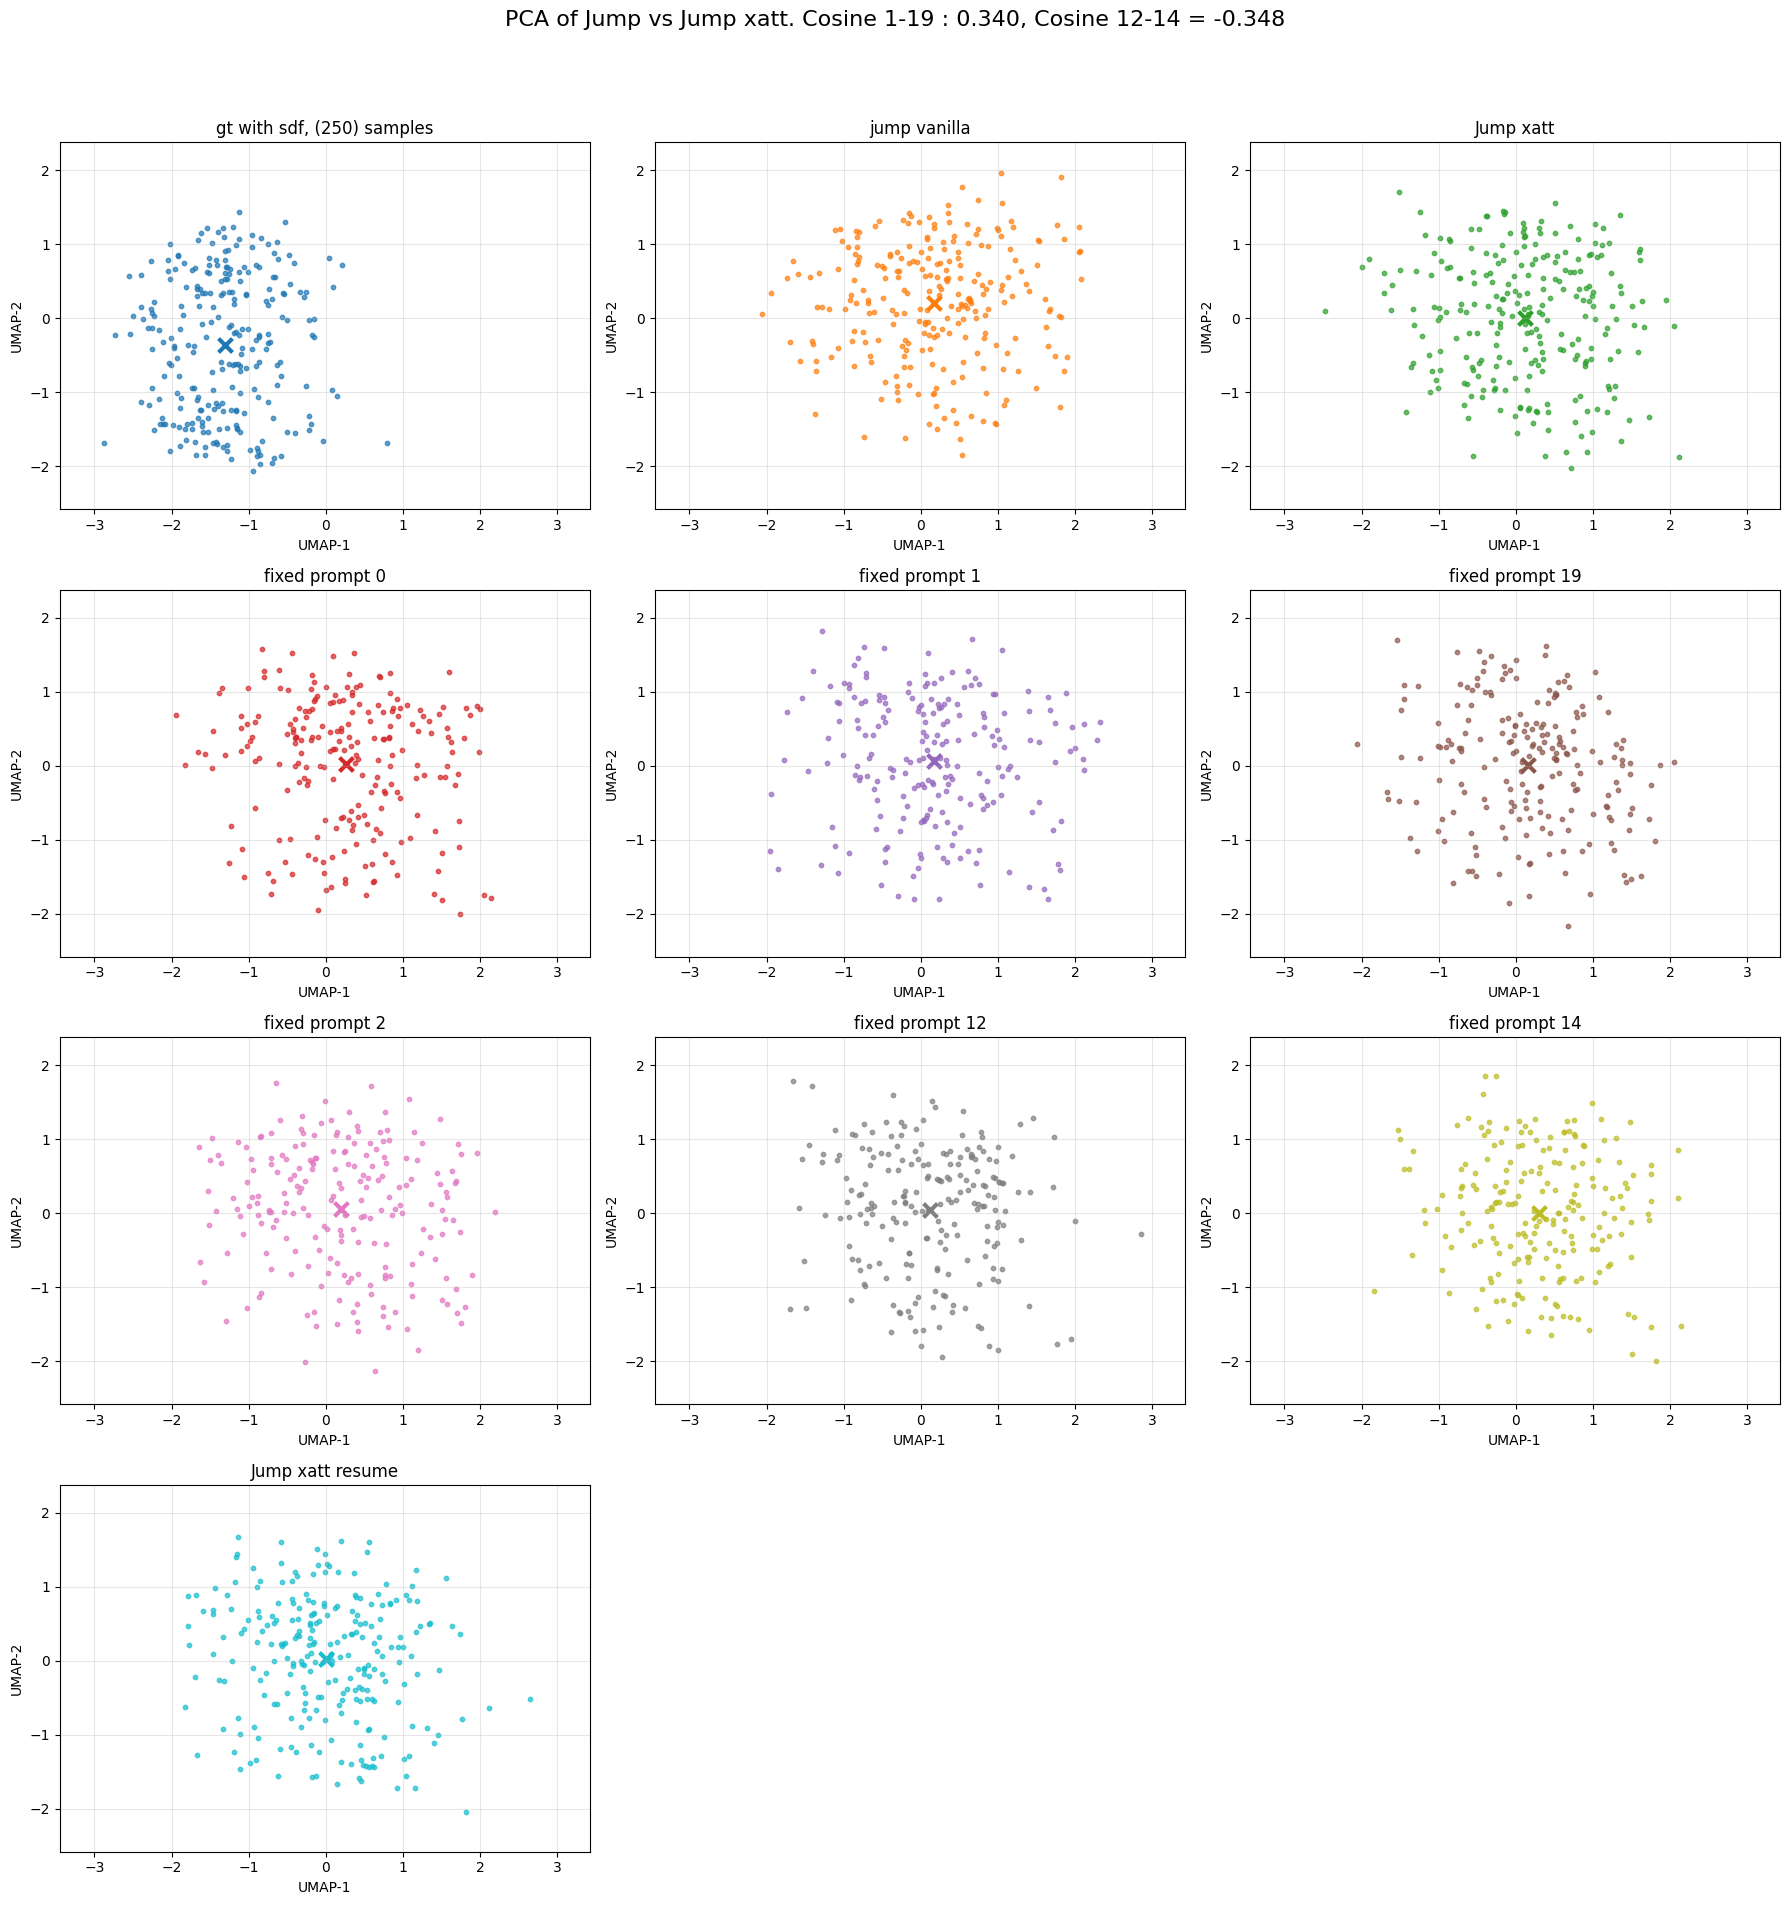

/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/import/pr_iktos/pierre/CondGeoLDM/metrics/fidelity.py:293: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


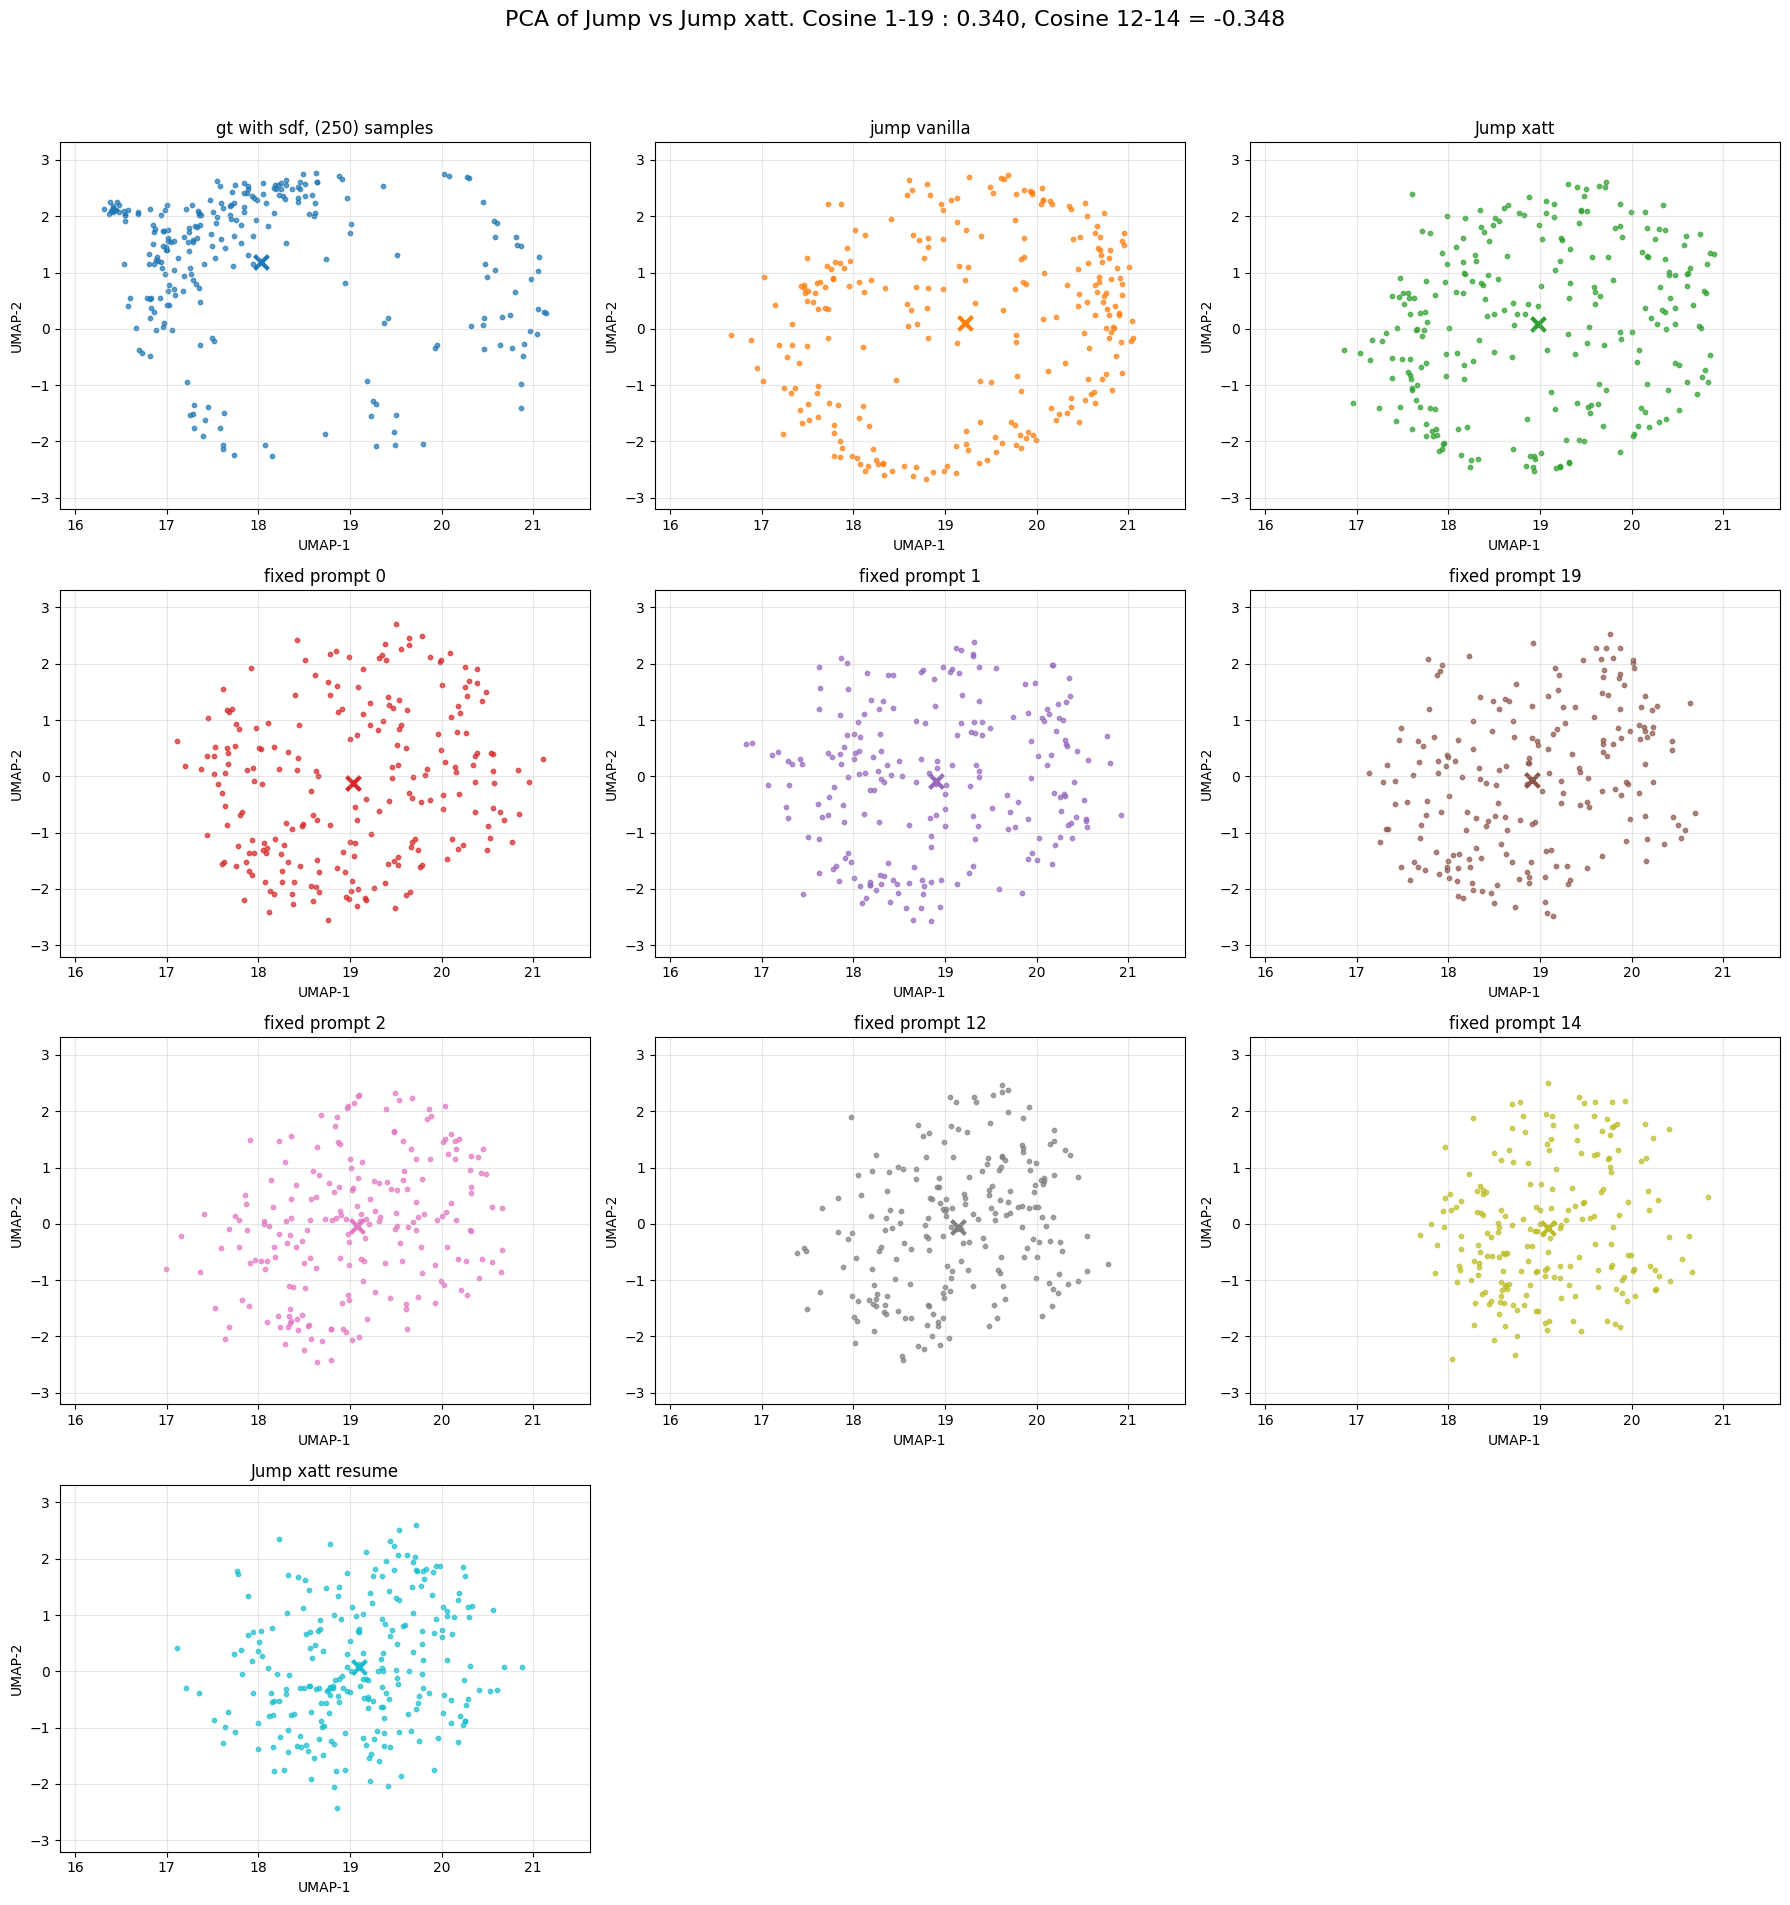

Explained variance ratios: [0.04507361 0.02148815]
Cumulative: [0.04507361 0.06656176]


/import/pr_iktos/pierre/CondGeoLDM/metrics/fidelity.py:293: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


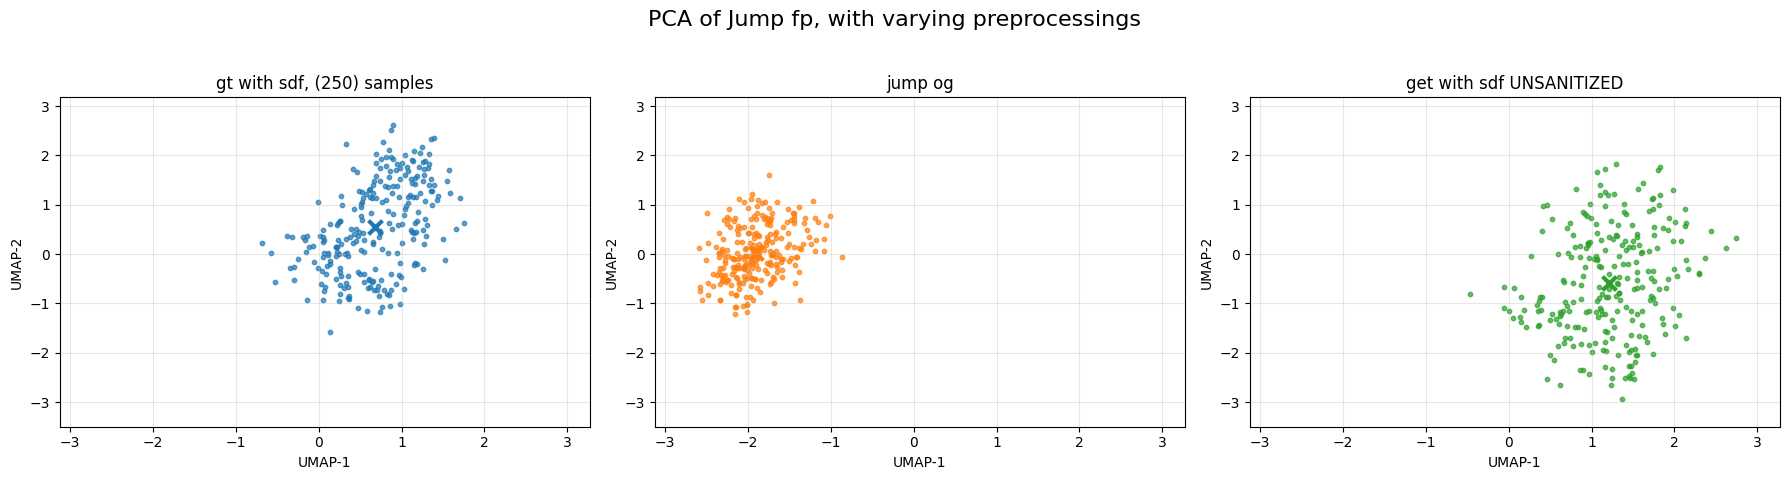

(array([[ 1.39385647,  2.35038368],
        [ 0.66015618,  1.40556765],
        [ 1.12531238,  1.90994322],
        ...,
        [ 1.39185157,  1.00809466],
        [ 1.54684686, -1.22344203],
        [ 1.78695014,  0.11883928]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 

In [ ]:
import metrics.fidelity as fidelity
from importlib import reload
reload(fidelity)
mask = np.random.choice(len(jump_fp_temp), size=250, replace=False)
vanilla_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpvanilla_from_jump.npy")
# xatt_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpxatt_from_jump.npy")
# prompt0_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen0_from_jump.npy")
# prompt1_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen1_from_jump.npy")
# prompt2_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen2_from_jump.npy")
# prompt12_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen12_from_jump.npy")
# prompt14_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen14_from_jump.npy")
# prompt19_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen19_from_jump.npy")
# xattresume3_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpxattresume3_from_jump.npy")
# fidelity.compute_stacked_umap([jump_fp[mask], vanilla_fp[:250], xatt_fp[:250], prompt0_fp, 
#                                prompt1_fp, prompt19_fp, prompt2_fp, prompt12_fp, prompt14_fp, xattresume3_fp[:250]],
#                               labels=[f"Jump gt ({len(mask)}) samples", "jump vanilla", "Jump xatt", "fixed prompt 0", 
#                                       "fixed prompt 1", "fixed prompt 19", "fixed prompt 2", "fixed prompt 12", 
#                                       "fixed prompt 14", "Jump xatt resume"],
#                               save_path="metrics/figures/umap_jump_vs_xatt.png",
#                               title="UMAP of Jump vs Jump xatt. Cosine 1-19 : 0.340, Cosine 12-14 = -0.348")
fidelity.compute_stacked_umap([jump_fp_unsanitized[mask], vanilla_fp[:250], xatt_fp[:250], prompt0_fp, 
                               prompt1_fp, prompt19_fp, prompt2_fp, prompt12_fp, prompt14_fp, xattresume3_fp[:250]],
                              labels=[f"gt with sdf, ({len(mask)}) samples", "jump vanilla", "Jump xatt", "fixed prompt 0", 
                                      "fixed prompt 1", "fixed prompt 19", "fixed prompt 2", "fixed prompt 12", 
                                      "fixed prompt 14", "Jump xatt resume"],
                              save_path="metrics/figures/umap_jump_vs_xatt.png",
                              title="PCA of Jump vs Jump xatt. Cosine 1-19 : 0.340, Cosine 12-14 = -0.348",
                              n_components=0.9,
                              use_umap=False)
fidelity.compute_stacked_umap([jump_fp_unsanitized[mask], vanilla_fp[:250], xatt_fp[:250], prompt0_fp, 
                               prompt1_fp, prompt19_fp, prompt2_fp, prompt12_fp, prompt14_fp, xattresume3_fp[:250]],
                              labels=[f"gt with sdf, ({len(mask)}) samples", "jump vanilla", "Jump xatt", "fixed prompt 0", 
                                      "fixed prompt 1", "fixed prompt 19", "fixed prompt 2", "fixed prompt 12", 
                                      "fixed prompt 14", "Jump xatt resume"],
                              save_path="metrics/figures/umap_jump_vs_xatt.png",
                              title="UMAP of Jump vs Jump xatt. Cosine 1-19 : 0.340, Cosine 12-14 = -0.348",
                              n_components=2,
                              use_umap=True)
fidelity.compute_stacked_umap([jump_fp_temp[mask], jump_fp[mask], jump_fp_unsanitized[mask]],
                              labels=[f"gt with sdf, ({len(mask)}) samples", "jump og", "get with sdf UNSANITIZED"],
                              save_path="metrics/figures/umap_jump_vs_xatt.png",
                              title="PCA of Jump fp, with varying preprocessings",
                              use_umap=False,
                              )

# fidelity.compute_stacked_umap_with_overlay([vanilla_fp, xatt_fp, prompt0_fp, 
#                                prompt1_fp, prompt19_fp, prompt2_fp, prompt12_fp, prompt14_fp],
#                               labels=["Jump vanilla", "Jump xatt", "fixed prompt 0", 
#                                       "fixed prompt 1", "fixed prompt 19", "fixed prompt 2", "fixed prompt 12", "fixed prompt 14"],
#                               save_path="metrics/figures/umap_jump_vs_xatt_overlay.png",
#                               title="UMAP of Jump vs Jump xatt. Cosine 1-19 : 0.340, Cosine 12-14 = -0.348")

/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


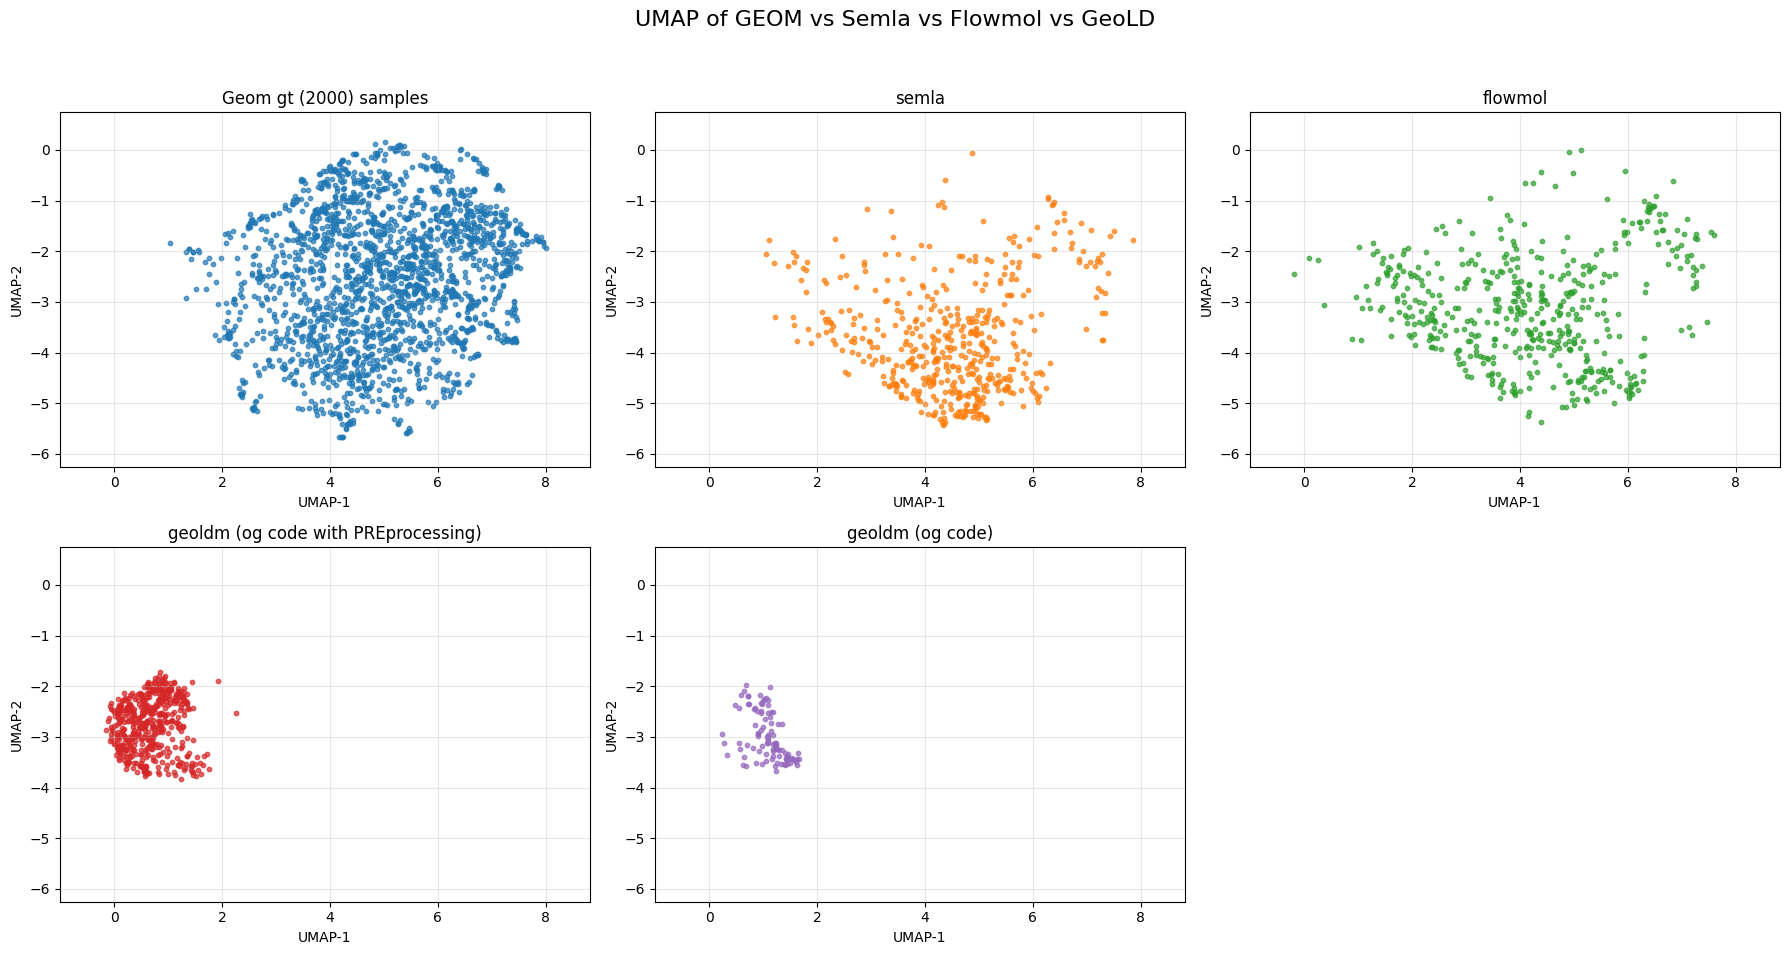

(array([[ 4.4447937 , -0.61107326],
        [ 6.0133348 , -3.609801  ],
        [ 5.7708564 , -2.5681806 ],
        ...,
        [ 1.4559456 , -3.4166696 ],
        [ 0.8354265 , -2.440187  ],
        [ 1.1406249 , -2.8746917 ]], dtype=float32),
 array([0, 0, 0, ..., 4, 4, 4]))

In [36]:
geom_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/geom_fingerprints.npy")
mask = np.random.choice(len(geom_fp), size=2000, replace=False)

semla_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_semla_from_geom.npy")
flowmol_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_flowmol_from_geom.npy")
geoldm_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_geoldm_from_geom.npy")
geoldm_ogmodel = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_geoldm_ogmodel_from_geom.npy")
geoldm_ogmodel_pp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_geoldm_ogmodel_pp_from_geom.npy")
geoldm_ogmodel_prep = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_geoldm_ogmodel_prep_from_geom.npy")
fidelity.compute_stacked_umap([geom_fp[mask], semla_fp[:500], flowmol_fp[:500], geoldm_ogmodel_prep[:500],  geoldm_ogmodel],
                              labels=[f"Geom gt ({len(mask)}) samples", "semla", "flowmol", "geoldm (og code with PREprocessing)", 
                                      "geoldm (og code)"],
                              save_path="metrics/figures/umap_geom_global.png",
                              title="UMAP of GEOM vs Semla vs Flowmol vs GeoLD",
                              )

/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score: 0.000


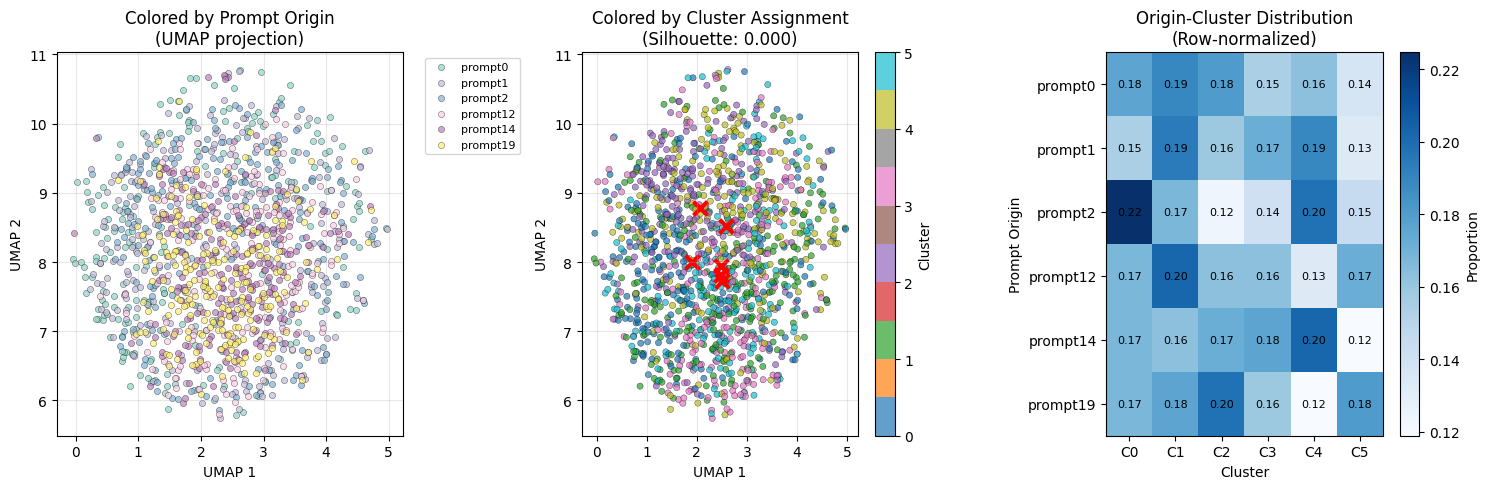


=== Clustering Analysis ===
Total samples: 1362
Feature dimensions: 1024
Number of clusters: 6

--- Samples per origin ---
prompt0: 227 samples
prompt1: 227 samples
prompt2: 227 samples
prompt12: 227 samples
prompt14: 227 samples
prompt19: 227 samples

--- Samples per cluster ---
Cluster 0: 240 samples
Cluster 1: 248 samples
Cluster 2: 226 samples
Cluster 3: 219 samples
Cluster 4: 228 samples
Cluster 5: 201 samples

--- Cluster purity (most common origin per cluster) ---
Cluster 0: prompt2 (21.25% purity)
Cluster 1: prompt12 (18.55% purity)
Cluster 2: prompt19 (19.91% purity)
Cluster 3: prompt14 (18.26% purity)
Cluster 4: prompt14 (20.18% purity)
Cluster 5: prompt19 (20.40% purity)


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
import umap

def analyze_prompt_clustering(prompt_fps_dict, n_clusters=6, use_umap=False, figsize=(15, 5)):
    """
    Comprehensive clustering analysis of prompt fingerprints
    
    Args:
        prompt_fps_dict: Dictionary with prompt names as keys and fingerprint arrays as values
        n_clusters: Number of clusters for KMeans
        use_umap: If True, use UMAP for dimensionality reduction, otherwise PCA
        figsize: Figure size for plots
    """
    
    # Prepare data more systematically
    prompt_names = list(prompt_fps_dict.keys())[:227]
    prompt_fps = list(prompt_fps_dict.values())[:227]
    
    # Stack all fingerprints
    X = np.vstack(prompt_fps)
    
    # Create labels for origin tracking
    labels_origin = []
    for name, fps in prompt_fps_dict.items():
        labels_origin.extend([name] * len(fps))
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Dimensionality reduction
    if use_umap:
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
        X_2d = reducer.fit_transform(X)
        method_name = "UMAP"
    else:
        pca = PCA(n_components=2, random_state=42)
        X_2d = pca.fit_transform(X)
        method_name = "PCA"
        print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    
    # Calculate clustering metrics
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot 1: Color by origin (prompt type)
    ax1 = axes[0]
    colors_origin = plt.cm.Set3(np.linspace(0, 1, len(prompt_names)))
    origin_color_map = {name: colors_origin[i] for i, name in enumerate(prompt_names)}
    
    for i, origin in enumerate(prompt_names):
        idx = [j for j, l in enumerate(labels_origin) if l == origin]
        if idx:  # Check if there are points for this origin
            ax1.scatter(X_2d[idx, 0], X_2d[idx, 1], 
                       c=[origin_color_map[origin]], label=origin, 
                       alpha=0.7, s=20, edgecolors='black', linewidths=0.3)
    
    ax1.set_title(f"Colored by Prompt Origin\n({method_name} projection)")
    ax1.set_xlabel(f"{method_name} 1")
    ax1.set_ylabel(f"{method_name} 2")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Color by cluster assignment
    ax2 = axes[1]
    colors_cluster = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    scatter = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, 
                         cmap='tab10', alpha=0.7, s=20, 
                         edgecolors='black', linewidths=0.3)
    
    # Add cluster centers
    if use_umap:
        # For UMAP, we can't directly transform cluster centers, so we approximate
        cluster_centers_2d = []
        for i in range(n_clusters):
            cluster_points = X_2d[cluster_labels == i]
            if len(cluster_points) > 0:
                center = np.mean(cluster_points, axis=0)
                cluster_centers_2d.append(center)
        cluster_centers_2d = np.array(cluster_centers_2d)
    else:
        # For PCA, we can transform the actual cluster centers
        cluster_centers_2d = pca.transform(kmeans.cluster_centers_)
    
    if len(cluster_centers_2d) > 0:
        ax2.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1], 
                   c='red', marker='x', s=100, linewidths=3, label='Centroids')
    
    ax2.set_title(f"Colored by Cluster Assignment\n(Silhouette: {silhouette_avg:.3f})")
    ax2.set_xlabel(f"{method_name} 1")
    ax2.set_ylabel(f"{method_name} 2")
    ax2.grid(True, alpha=0.3)
    
    # Create colorbar for clusters
    cbar = plt.colorbar(scatter, ax=ax2, ticks=range(n_clusters))
    cbar.set_label('Cluster')
    
    # Plot 3: Cluster composition analysis
    ax3 = axes[2]
    
    # Create confusion matrix between origins and clusters
    confusion_data = np.zeros((len(prompt_names), n_clusters))
    for i, origin in enumerate(prompt_names):
        origin_indices = [j for j, l in enumerate(labels_origin) if l == origin]
        origin_clusters = cluster_labels[origin_indices]
        for cluster in range(n_clusters):
            confusion_data[i, cluster] = np.sum(origin_clusters == cluster)
    
    # Normalize by row (by origin) to show percentages
    confusion_normalized = confusion_data / confusion_data.sum(axis=1, keepdims=True)
    
    im = ax3.imshow(confusion_normalized, cmap='Blues', aspect='auto')
    ax3.set_xticks(range(n_clusters))
    ax3.set_yticks(range(len(prompt_names)))
    ax3.set_xticklabels([f'C{i}' for i in range(n_clusters)])
    ax3.set_yticklabels(prompt_names)
    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Prompt Origin')
    ax3.set_title('Origin-Cluster Distribution\n(Row-normalized)')
    
    # Add text annotations
    for i in range(len(prompt_names)):
        for j in range(n_clusters):
            text = ax3.text(j, i, f'{confusion_normalized[i, j]:.2f}', 
                           ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax3, label='Proportion')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\n=== Clustering Analysis ===")
    print(f"Total samples: {len(X)}")
    print(f"Feature dimensions: {X.shape[1]}")
    print(f"Number of clusters: {n_clusters}")
    
    print("\n--- Samples per origin ---")
    for name, fps in prompt_fps_dict.items():
        print(f"{name}: {len(fps)} samples")
    
    print("\n--- Samples per cluster ---")
    unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
    for cluster, count in zip(unique_clusters, counts):
        print(f"Cluster {cluster}: {count} samples")
    
    print("\n--- Cluster purity (most common origin per cluster) ---")
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_origins = [labels_origin[i] for i in cluster_indices]
        if cluster_origins:
            most_common = max(set(cluster_origins), key=cluster_origins.count)
            purity = cluster_origins.count(most_common) / len(cluster_origins)
            print(f"Cluster {cluster}: {most_common} ({purity:.2%} purity)")
    
    return {
        'X_2d': X_2d,
        'cluster_labels': cluster_labels,
        'labels_origin': labels_origin,
        'silhouette_score': silhouette_avg,
        'kmeans_model': kmeans
    }

# Example usage with your data structure:
prompt_fps_dict = {
    "prompt0": prompt0_fp[:227],
    "prompt1": prompt1_fp[:227], 
    "prompt2": prompt2_fp[:227],
    "prompt12": prompt12_fp[:227],
    "prompt14": prompt14_fp[:227],
    "prompt19": prompt19_fp[:227]
}

# Run the analysis
results = analyze_prompt_clustering(prompt_fps_dict, n_clusters=6, use_umap=True)

In [17]:
from pathlib import Path
import pickle
from qm9 import dataset

io_path = Path("/import/pr_iktos/pierre/CondGeoLDM")

with open(io_path / "outputs/jump_xatt_h_3000%_25e_resume" /  "args.pickle", "rb") as f:
    args = pickle.load(f)
dataloaders, _ = dataset.retrieve_dataloaders(args)

Loading JUMP dataset from /projects/iktos/pierre/CondGeoLDM/data/jump/charac_30_h.npy


In [22]:
test_loader = dataloaders["test"]
for batch in test_loader:
    emb = batch["embeddings"].clone()
    break
emb[0]

tensor([ 0.0490,  0.3142, -0.1713,  ...,  0.6353, -0.4829,  0.1525])

In [34]:
import torch.nn.functional as F
print(prompt12_fp[:,0], prompt14_fp[:,0])
cos_sim01 = F.cosine_similarity(emb[1], emb[0], dim=0)
print("Cosine between prompts 0 & 1:" , cos_sim01)
cos_sim02 = F.cosine_similarity(emb[0], emb[19], dim=0)
print("Cosine between 0 & 19:", cos_sim02)
cos_sim12 = F.cosine_similarity(emb[1], emb[19], dim=0)
print("Cosine between 1 & 19:", cos_sim12)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
Cosine between prompts 0 & 1: tensor(-0.0071)
Cosine between 0 &

In [28]:
max_sim = 0
min_sim = 0
all_cos_sims = []
indices = [0, 1, 2, 12, 14, 19]
all_cos_sims = []

for idx, i in enumerate(indices):
    for j in indices[idx+1:]:
        cos_sim = F.cosine_similarity(emb[i], emb[j], dim=0)
        all_cos_sims.append(cos_sim.item())
        print(f"Cosine similarity between {i} and {j}: {cos_sim.item()}")
        # if (cos_sim)> max_sim:
        #     max_sim = cos_sim
        #     print(f"New max sim: {max_sim} between {i} and {j}")
        # if (cos_sim) < min_sim:
        #     min_sim = cos_sim
        #     print(f"New min sim: {min_sim} between {i} and {j}")

# plot all cosi histogram 

# import matplotlib.pyplot as plt
# plt.hist(all_cos_sims, bins=50)
# plt.title("Cosine similarities between 32 embeddings")
# plt.xlabel("Cosine similarity")
# plt.ylabel("Frequency")     
# # plt.savefig("metrics/figures/cosine_similarities_histogram.png")
# plt.show() 



Cosine similarity between 0 and 1: -0.007125344127416611
Cosine similarity between 0 and 2: 0.05235643312335014
Cosine similarity between 0 and 12: 0.10128151625394821
Cosine similarity between 0 and 14: -0.14918577671051025
Cosine similarity between 0 and 19: -0.07063275575637817
Cosine similarity between 1 and 2: 0.019359834492206573
Cosine similarity between 1 and 12: 0.10365933179855347
Cosine similarity between 1 and 14: -0.14346016943454742
Cosine similarity between 1 and 19: 0.3401736915111542
Cosine similarity between 2 and 12: 0.0925578698515892
Cosine similarity between 2 and 14: -0.07008595019578934
Cosine similarity between 2 and 19: 0.025376267731189728
Cosine similarity between 12 and 14: -0.34788158535957336
Cosine similarity between 12 and 19: 0.09008188545703888
Cosine similarity between 14 and 19: -0.08107537776231766


# Checking molecular property distribution

Processing Jump Vanilla...
Processing Jump xatt...
Processing Jump xatt resume3...
Processing prompt0...
Processing prompt1...
Processing prompt2...
Processing prompt12...
Processing prompt14...
Processing prompt19...
Processing Jump Ground Truth...
Dataset              Molecules  Atoms (μ±σ)     LogP (μ±σ)      Top Atom  
--------------------------------------------------------------------------------


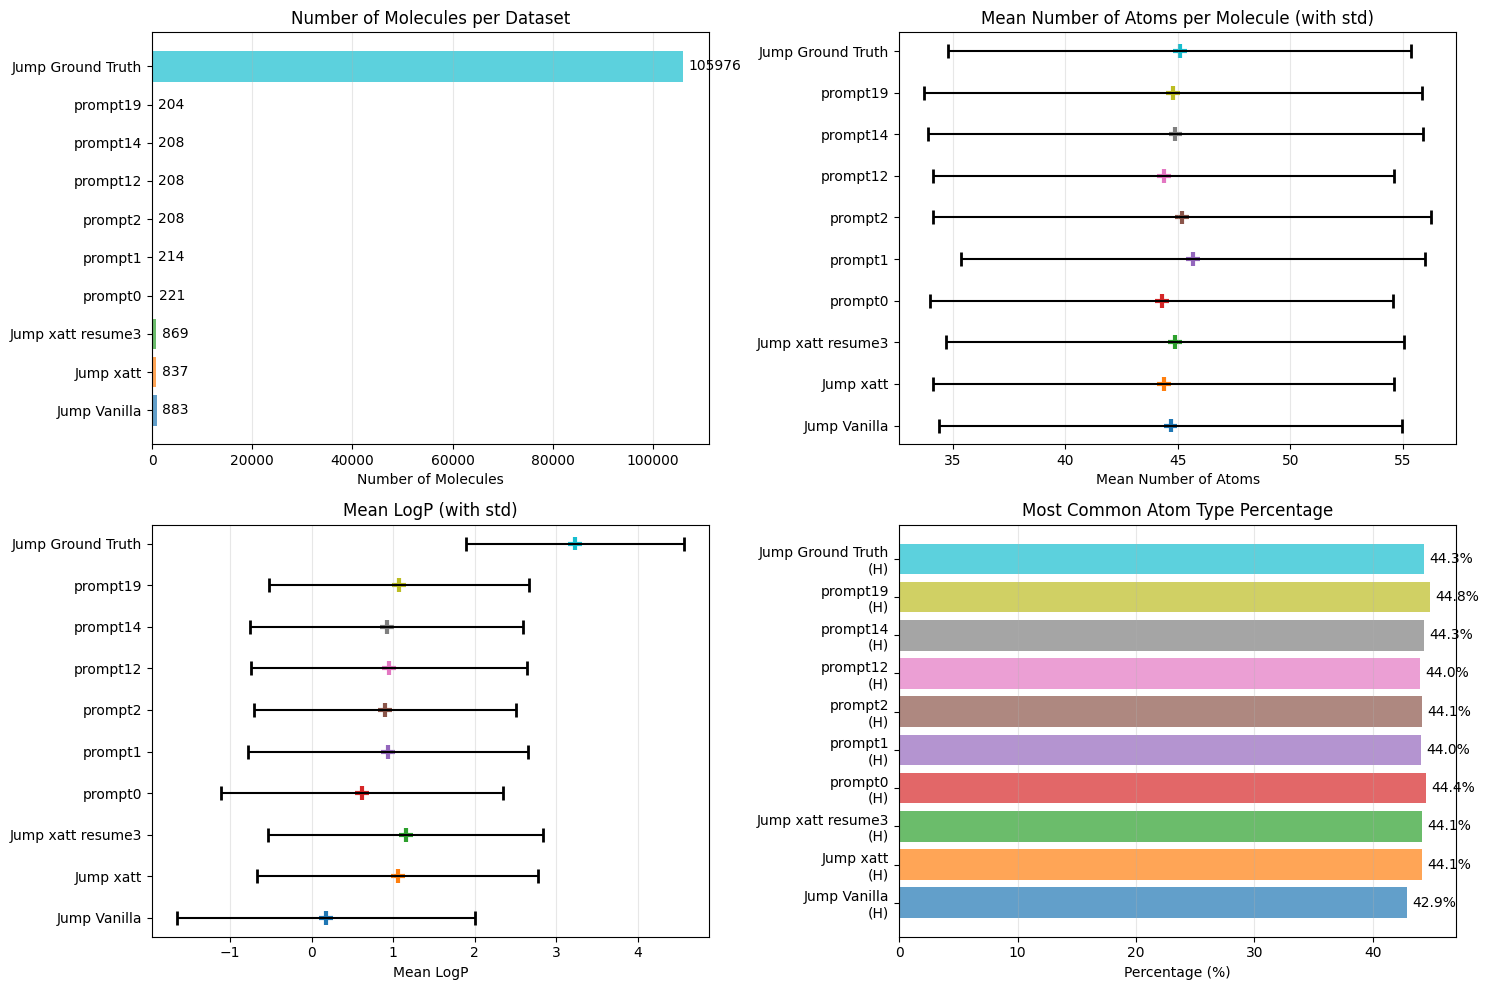

In [31]:
reload(fidelity)
# Load molecules from SDF
sdf_paths = ["/projects/iktos/pierre/sampled_mols/jump/1000vanilla.sdf", 
             "/projects/iktos/pierre/sampled_mols/jump/1000xatt.sdf",
            "/projects/iktos/pierre/sampled_mols/jump/1000xattresume3.sdf",
            "/projects/iktos/pierre/sampled_mols/jump/250xattfixed0.sdf",
            "/projects/iktos/pierre/sampled_mols/jump/250xattfixed1.sdf",
            "/projects/iktos/pierre/sampled_mols/jump/250xattfixed2.sdf",
            "/projects/iktos/pierre/sampled_mols/jump/250xattfixed12.sdf",
            "/projects/iktos/pierre/sampled_mols/jump/250xattfixed14.sdf",
            "/projects/iktos/pierre/sampled_mols/jump/250xattfixed19.sdf",
            "/projects/iktos/pierre/CondGeoLDM/data/jump/raw_data/jump_molecules.sdf",
             ]
labels = ["Jump Vanilla", 
          "Jump xatt", 
          "Jump xatt resume3",
          "prompt0",
          "prompt1",
          "prompt2",
          "prompt12",
          "prompt14",
          "prompt19",
          "Jump Ground Truth"
          ]
results = fidelity.count_molecular_properties(sdf_paths, labels, verbose=False)